<a href="https://colab.research.google.com/github/kwanda2426/projects/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [114]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import plotly.express as px

from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
import missingno as msno

#Feature engineering, selection and Model training
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.feature_selection import SelectKBest, f_regression

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from tabulate import tabulate


# **Importing Data**

In [115]:
# Reading data
file_path = "https://raw.githubusercontent.com/kwanda2426/projects/main/insurance.csv"
df = pd.read_csv(file_path)


In [116]:
# Showing first 5 lines of data
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [117]:
#data columns
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [118]:
# Rows and Columns of data
print('Data has {} rows and {} Columns'.format(df.shape[0],df.shape[1]))
print('')
print('Data has the following columns:')
for i in df.columns:
  print(i)

Data has 1338 rows and 7 Columns

Data has the following columns:
age
sex
bmi
children
smoker
region
charges


### Data Type of Columns

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Data set has no missing values, with a mixture of both categorical and numerical features.

## Describing the variables

In [120]:
#describing numerical columns
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [121]:
#describing categorical variables
cat_cols = df.select_dtypes(include=["object", "category"])
for i in cat_cols.columns:
  a = df[i].unique()
  print('unique categories for '+ i.upper() + ' is(are) :{}'.format(a))
  print('')


unique categories for SEX is(are) :['female' 'male']

unique categories for SMOKER is(are) :['yes' 'no']

unique categories for REGION is(are) :['southwest' 'southeast' 'northwest' 'northeast']



In [122]:
#Defining the variables
variables = {
    "Variable": ["age", "sex", "bmi", "children", "smoker", "region", "charges"],
    "Description": [
        "Age of the insured individual (between 18 and 64).",
        "Gender of the insured person (male or female).",
        "Body Mass Index, a measure of body fat based on height and weight (between 15 and 54).",
        "Number of dependent children covered by the insurance plan (between 0 and 5).",
        "Smoking status of the individual (yes or no).",
        "Residential area (northeast, northwest, southeast, southwest).",
        "Final insurance cost billed to the individual (between 1121 and 63770)."
    ]
}
# Create the DataFrame
var_desc = pd.DataFrame(variables)
var_desc.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(tabulate(var_desc, headers='keys', tablefmt='pretty'))


+---+----------+----------------------------------------------------------------------------------------+
|   | Variable |                                      Description                                       |
+---+----------+----------------------------------------------------------------------------------------+
| 0 |   age    |                   Age of the insured individual (between 18 and 64).                   |
| 1 |   sex    |                     Gender of the insured person (male or female).                     |
| 2 |   bmi    | Body Mass Index, a measure of body fat based on height and weight (between 15 and 54). |
| 3 | children |     Number of dependent children covered by the insurance plan (between 0 and 5).      |
| 4 |  smoker  |                     Smoking status of the individual (yes or no).                      |
| 5 |  region  |             Residential area (northeast, northwest, southeast, southwest).             |
| 6 | charges  |        Final insurance cost b

The categorical variables will need to be encoded if they will be used in building the model.

# **Exploratory Data Analysis**

This method is meant to uncover the underlying structure of a data set and is important for a company because it exposes trends, patterns, and relationships that are not readily apparent.

## **Correlation**
This is meant to discover :
- Relationship between features and target variable.
- Multicollinearity - where features are highly correlated to each other. This guides whether to combine features or not as this means that features carry the same information.
- Most informative features. This helps to (simplify the model, reduce noise and improve predictive accuracy) by focusing on informative features only.
- Patterns such as if one feature increases, so does another OR One decreases , the other increases.
- +1 shows a strong positive correlation and -1 shows a strong negative correlation.


In [123]:
# Compute correlation matrix
df_corr = df.copy()
corr_matrix = df_corr.corr(numeric_only=True)

# Create heatmap
fig = px.imshow(
    corr_matrix,
    text_auto = True,
    color_continuous_scale = 'RdBu',
    zmin = -1, zmax = 1,
    title = 'Feature Correlation Heatmap'
)

fig.update_layout(
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


- There's a positive strong correlation between age and charges. This means that as the age increases so do insurances.
- There's a strong correlation between BMI and Charges, which is expected because BMI is a function of Age.
- Positive correlation between BMI and age is not strong enough to drop one of these features even though they are related. Model performance will guide if one feature must be dropped.

## **Feature Distribution**
This is meant to discover :
- Relationship between features and target variable. This should help see if a feature that was not caught by correlation because of datatype(especially categorical) has a relationship with the target variable. This helps in encoding categorical features. For an example, with the region in our dataset. It could be that the feature does not affect charges at all, or some regions have more impact than others.

###**Gender(sex) Distribution**

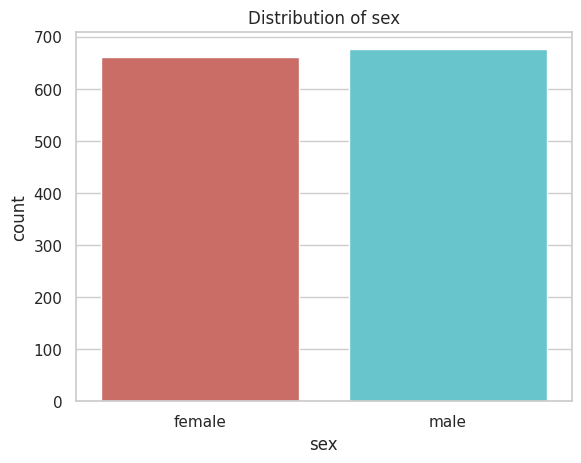

In [124]:
#countplot of sex (between males and females)
df_1 = df.copy()
sns.countplot(x = 'sex', data = df_1, palette = "hls")
plt.title("Distribution of sex");

These two groups are approximately well represented in our dataset, hence there's expected bias in our model predictions with regards to this feature.

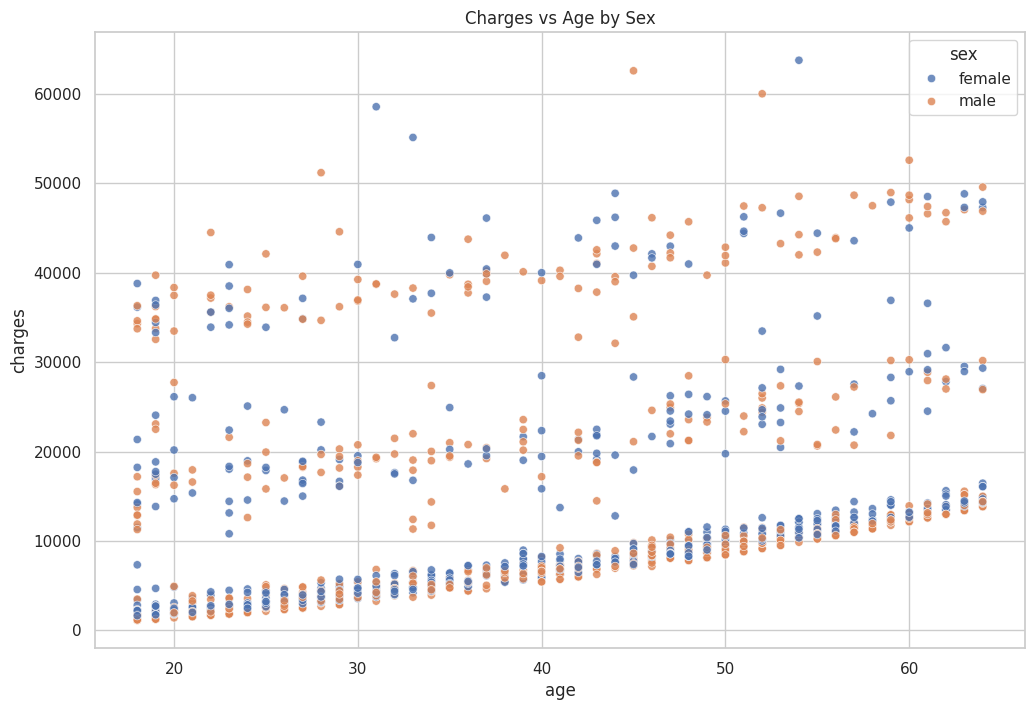

In [125]:
#distribution of charges per age group, by gender
df_1 = df.copy()
plt.figure(figsize = (12,8))
sns.scatterplot(data = df_1, x ="age", y = "charges", hue = "sex", alpha=0.8, sizes=(40,200))
plt.title("Charges vs Age by Sex")
plt.show()

Here it is clear that it does not matter whether someone is male or female when it comes to insurance charges. An upward trend is seen between charges and Age.

In [126]:
# Group by gender and smoker status, then calculate average charges
df_1 = df.copy()
df_temp = df_1.groupby(['sex', 'smoker'], as_index = False)['charges'].mean()

# Stacked bar chart
fig = px.bar(df_temp,
             x = 'sex',
             y = 'charges',
             color = 'smoker',
             title = 'Average Charges per Gender (Stacked by Smoking Status)',
             labels = {'charges': 'Average Charges', 'sex': 'Gender', 'smoker': 'Smoking Status'},
             text = 'charges')

fig.update_traces(texttemplate = '%{text:.2f}', textposition='inside')
fig.update_layout(barmode = 'stack', uniformtext_minsize = 8, uniformtext_mode = 'hide')
fig.show()

On Average Male charges are slightly above Average Female, but not by a significant amount. This view conform to what is shown above that Gender(sex) does have a significant impact on insurance charges. This feature might not be useful to predict charges, but dropping it should be guided by model performance.

###**Region Distribution**

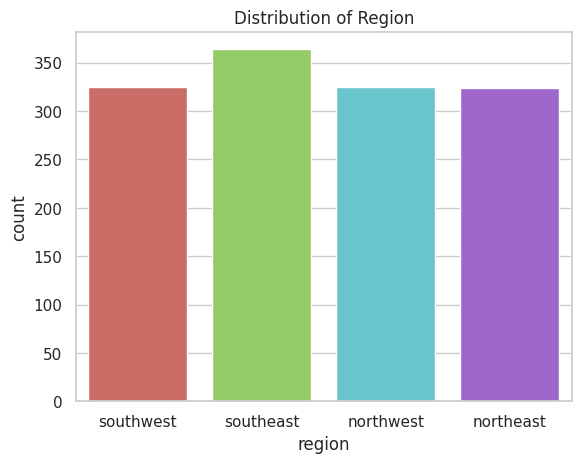

In [127]:
#countplot of Region
df_1 = df.copy()
sns.countplot(x = 'region', data = df_1, palette = "hls")
plt.title("Distribution of Region");

Looks like all regions are fairly represented in the dataset. Should this feature be included in model building, there would not be a bias expected.

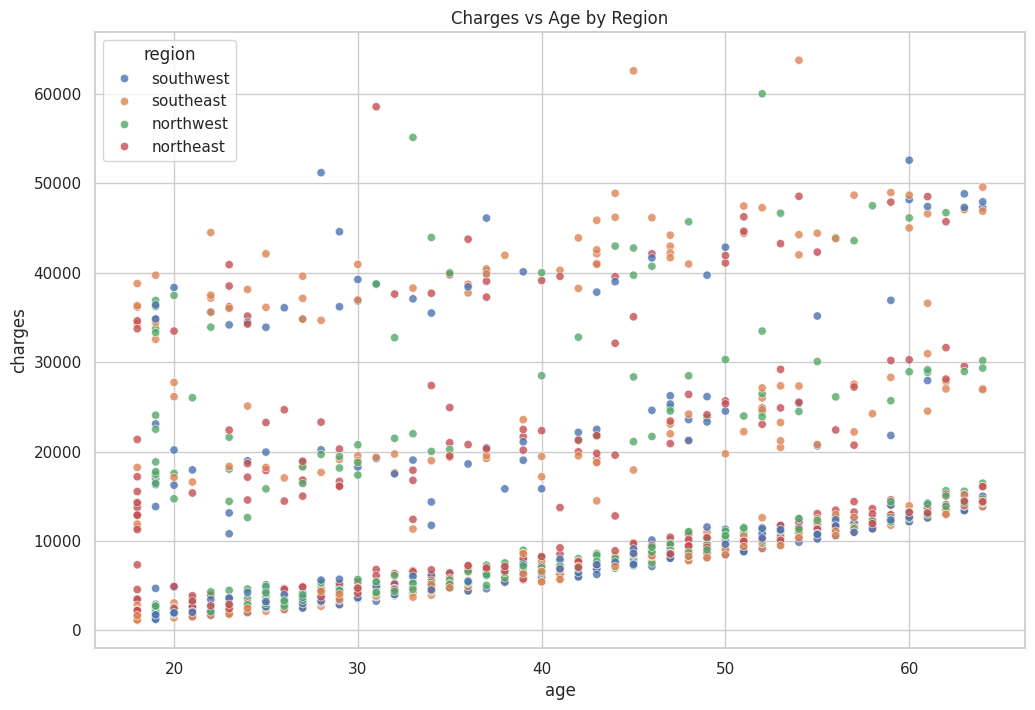

In [128]:
#distribution of charges per age group, by region
df_1 = df.copy()
plt.figure(figsize = (12,8))
sns.scatterplot(data = df_1, x = "age", y = "charges", hue = "region", alpha=0.8, sizes=(40,200))
plt.title("Charges vs Age by Region")
plt.show()

This views shows that all these regions are fairly represented even with age. The trend that is visible is the increase in charges as the age increases.

In [129]:
# Group by region and smoker status, then calculate average charges
df_1 = df.copy()
df_temp = df_1.groupby(['region', 'smoker'], as_index = False)['charges'].mean()

# Stacked bar chart
fig = px.bar(df_temp,
             x = 'region',
             y = 'charges',
             color = 'smoker',
             title = 'Average Charges per Region (Stacked by Smoking Status)',
             labels = {'charges': 'Average Charges', 'region': 'Region', 'smoker': 'Smoking Status'},
             text = 'charges')

fig.update_traces(texttemplate = '%{text:.2f}', textposition='inside')
fig.update_layout(barmode = 'stack', uniformtext_minsize = 8, uniformtext_mode = 'hide')
fig.show()

- It is clear that it does matter significantly in which region one comes from when it comes to charges, but the smoking status does. It is clear how significant the charges increase when someone is a smoker.

###**Age Distribution**

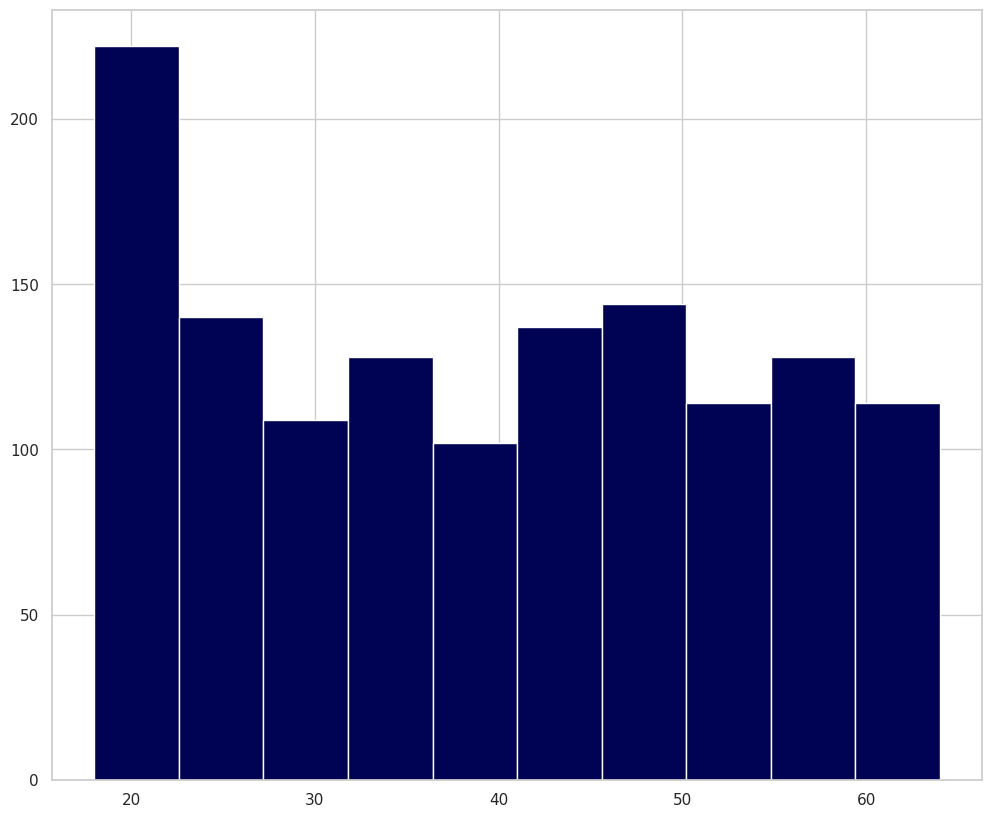

In [130]:
df_1 = df.copy()
features = 'age'
df_1[features].hist(figsize = (12,10),  color = '#000354');

Most data points are of the age 20. The other age groups are fairly represented as well.

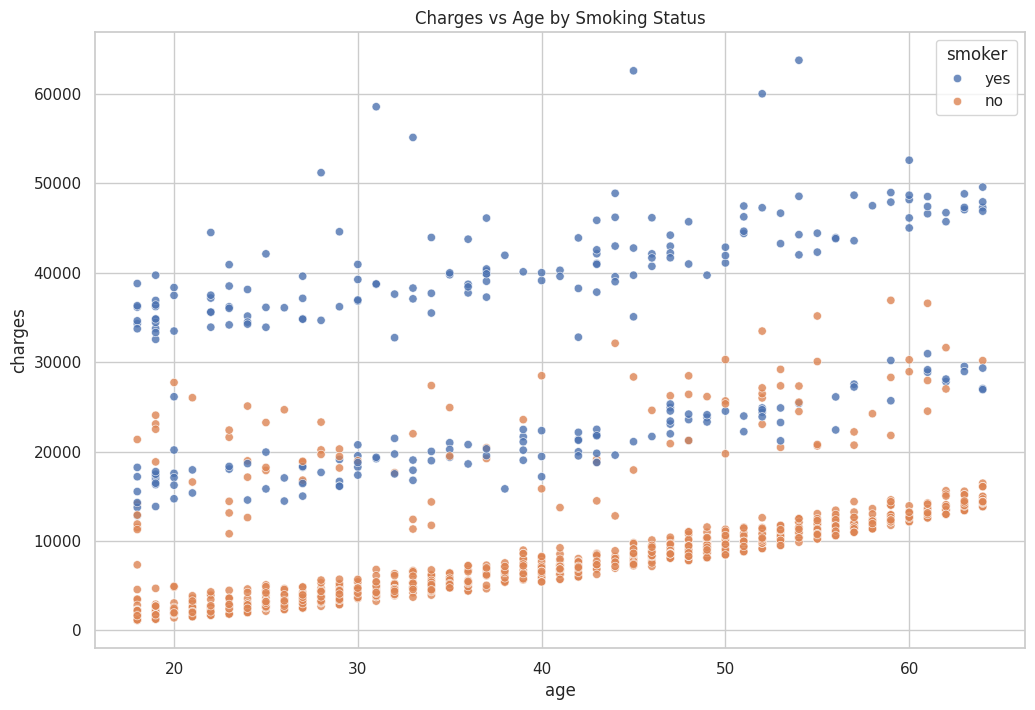

In [131]:
#distribution of charges per age group, by smoking status
df_1 = df.copy()
plt.figure(figsize = (12,8))
sns.scatterplot(data = df_1, x = "age", y = "charges", hue = "smoker", alpha=0.8, sizes=(40,200))
plt.title("Charges vs Age by Smoking Status")
plt.show()

- There is a clear trend that irregardless of age, smokers end up paying more charges.
- Where charges are less than 10k - This comprises of non-smokers for all age groups.
- Whether charges are between 10k and 30k, both non-smokers and smokers are fairly represented and this is where we have average charges per age group.
- Where charges are greater than 30k - This group consists of virtually smokers.

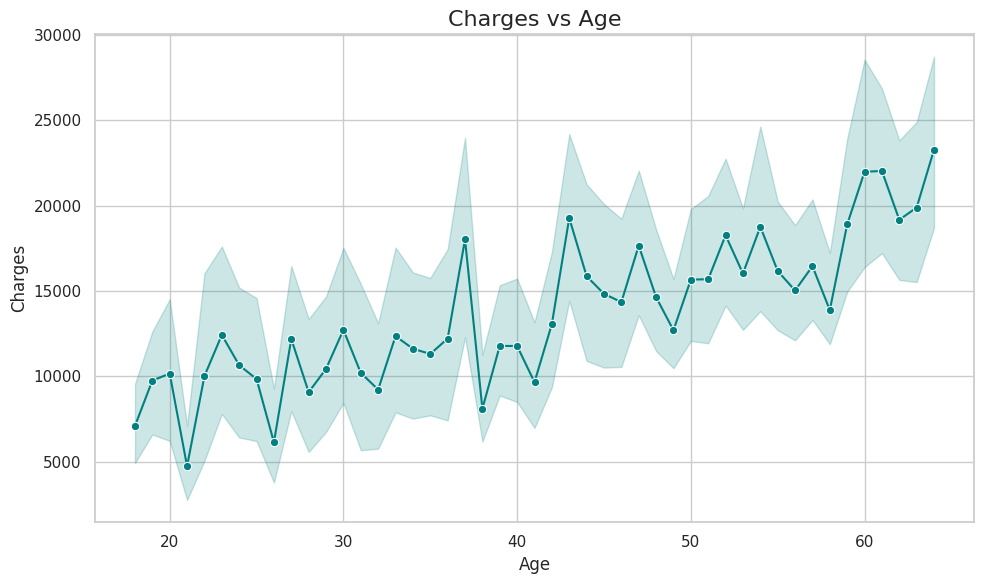

In [132]:
# Create DataFrame
df_1 = df.copy()

# Set Seaborn style
sns.set(style="whitegrid")

# Create line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x = 'age', y = 'charges', data = df_1, marker='o', color='teal')

# Add labels and title
plt.title('Charges vs Age', fontsize=16)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Charges', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

Age definitely does have an impact in charges. As the age increases so do charges. Older people are charge a lot.

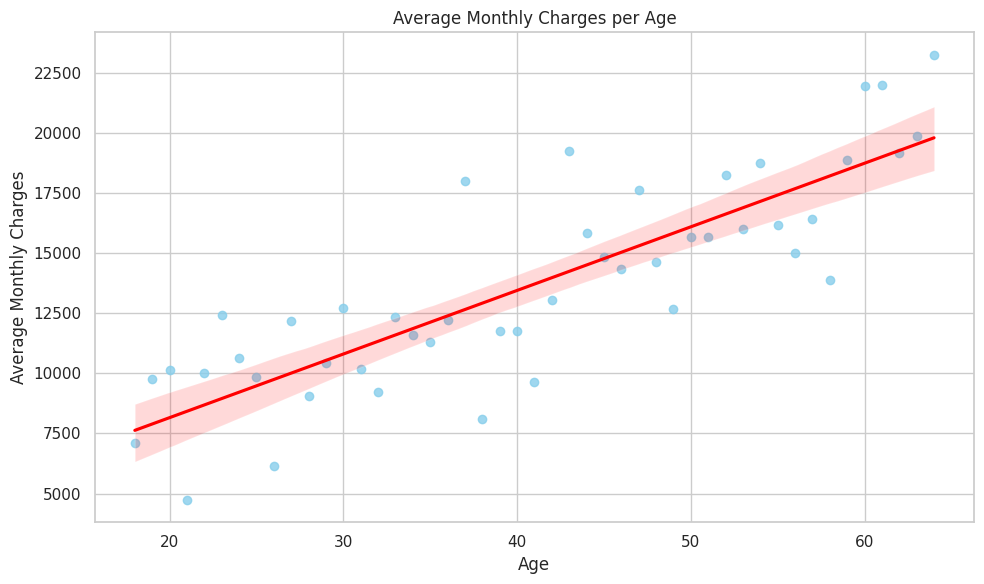

In [133]:
# Average Monthly charges vs age
df_1 = df.copy()
df_temp = df_1.groupby('age')['charges'].mean().reset_index()
# Plot
plt.figure(figsize=(10, 6))
sns.regplot(data = df_temp, x = 'age', y = 'charges', scatter = True, color = 'skyblue', line_kws = {'color': 'red'})
plt.title('Average Monthly Charges per Age')
plt.xlabel('Age')
plt.ylabel('Average Monthly Charges')
plt.grid(True)
plt.tight_layout()
plt.show()

Trend is going up between charges and age. This shows a strong positive correlation between these two features.

# **Feature Selection and Engineering**


- This dataset does not have a lot of features(6). It is better to build the model first and see performance before dropping features.
- In terms of feature engineering, the categorical variables are converted to numerical variables using label encoding.



In [134]:
# encoding categorical features
def Label_Encoder(df_1):
  columnsToEncode = list(df.select_dtypes(include=['category','object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
    df[feature] = le.fit_transform(df[feature])
  return df

# final dataframe
df_1 = df.copy()
df_final = Label_Encoder(df_1)

In [135]:
df_final.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# **Model Building and Testing**

In [136]:
# splitting dataset into training and testing
df_data = df_final.copy()
X = df_data.drop(['charges'], axis = 1)
Y = df_data['charges']

# 80% train and 20% test -- random state = 42, ensure the reproducibility of the data split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [137]:
# initialise model
model = LinearRegression()

#train model
model.fit(x_train, y_train)

LinearRegression()

# **Model Evaluation**

In [138]:
print(model.coef_)
print(model.score(x_test, y_test))

[ 2.57056264e+02 -1.87914567e+01  3.35781491e+02  4.25091456e+02
  2.36478181e+04 -2.71284266e+02]
0.7833463107364539


**Regression Evaluation Metrics**

In [139]:
# Making Predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [140]:
#Model evaluation
from sklearn.metrics import mean_squared_error

metrics = {
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Training': [round(np.sqrt(mean_squared_error(y_train, y_train_pred)),4), round(model.score(x_train, y_train),4)],
    'Testing data': [round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4),round(model.score(x_test, y_test),4)
    ]
}
# Create the DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(tabulate(metrics_df, headers = 'keys', tablefmt = 'pretty'))

+---+-------------------------+-----------+--------------+
|   |         Metric          | Training  | Testing data |
+---+-------------------------+-----------+--------------+
| 0 | Root Mean Squared Error | 6105.7893 |  5799.5871   |
| 1 |        R-squared        |  0.7417   |    0.7833    |
+---+-------------------------+-----------+--------------+


## **Scaling data to check if performance improves**

In [141]:
df_2 = df_final.copy()


x = df_2.drop(['charges'], axis=1)
y = df_2['charges']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)

# 🧪 Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# initialise model
model_1 = LinearRegression()

#train model
model_1.fit(X_train, y_train)


LinearRegression()

In [142]:
# Making Predictions
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

In [143]:
#Model evaluation
from sklearn.metrics import mean_squared_error

metrics = {
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Training': [round(np.sqrt(mean_squared_error(Y_train, y_pred_train)),4), round(model.score(x_train, Y_train),4)],
    'Testing data': [round(np.sqrt(mean_squared_error(Y_test, y_pred_test)),4),round(model.score(x_test, Y_test),4)
    ]
}
# Create the DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(tabulate(metrics_df, headers = 'keys', tablefmt = 'pretty'))

+---+-------------------------+-----------+--------------+
|   |         Metric          | Training  | Testing data |
+---+-------------------------+-----------+--------------+
| 0 | Root Mean Squared Error | 6105.7893 |  5799.5871   |
| 1 |        R-squared        |  0.7417   |    0.7833    |
+---+-------------------------+-----------+--------------+


- We can see that the performance of our model stays the same. The model has a good training and Testing R-squared. It did not drop, but increase when using the testing data.